參考自 https://github.com/567-labs/systematically-improving-rag/tree/main/cohort_2/week1

### 合成問題

In [1]:
import os
from pathlib import Path
from dotenv import load_dotenv
load_dotenv(".env", override=True)

from openai import OpenAI
client = OpenAI()

from openai import AsyncOpenAI
async_client = AsyncOpenAI()

In [2]:
import sqlite3

# Read documents from local database
def load_documents_from_db():
    """Load documents from the local SQLite database"""
    db_path = "data/documents.db"
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    
    try:
        # Query documents table
        cursor.execute("SELECT id, content FROM documents")
        rows = cursor.fetchall()
        
        # Convert to dictionary with id as key and content as value
        documents_dict = {str(row[0]): row[1] for row in rows}
        
        return documents_dict
    
    finally:
        conn.close()

# Load documents
documents = load_documents_from_db()
print(f"Loaded {len(documents)} documents from database")

# Show first document as example
if documents:
    first_doc_id = list(documents.keys())[0]
    print(f"First document ID: {first_doc_id}")
    print(f"Content preview: {documents[first_doc_id][:200]}...")


Loaded 10 documents from database
First document ID: 1
Content preview: 【注意事項 】本行所提供之資訊僅供參考用途。本行當盡力提供正確之資訊，所載資料均來自或本諸我們相信可靠之來源，但對其完整性、即時性和正確性
不做任何擔保，如有錯漏或疏忽，本行並不負任何法律責任。任何人因信賴此等資料而做出或改變投資決策，應審慎衡量本身之需求及投資之風險，並就投
資結果自行負責。未經本公司許可，本資料及訊息不得逕行抄錄、翻印或另作派發。本行以上市場資訊與分析，不涉及特定投資標的之建議...


In [3]:
documents

{'1': '【注意事項 】本行所提供之資訊僅供參考用途。本行當盡力提供正確之資訊，所載資料均來自或本諸我們相信可靠之來源，但對其完整性、即時性和正確性\n不做任何擔保，如有錯漏或疏忽，本行並不負任何法律責任。任何人因信賴此等資料而做出或改變投資決策，應審慎衡量本身之需求及投資之風險，並就投\n資結果自行負責。未經本公司許可，本資料及訊息不得逕行抄錄、翻印或另作派發。本行以上市場資訊與分析，不涉及特定投資標的之建議。1AI與智慧手機展望樂觀\n分析師／張乘維\n研究範疇／科技科技產業投資攻略\n出刊日:2025/10/29\n熱門議題 /投資關鍵\n《科技巨頭財報 ，蘋果與微軟有望優於預期 》\n蘋果、微軟、輝達佔標普科技獲利比重約 18-21%，\n三者合計高達 6成，本行認為蘋果 iPhone銷售、微\n軟Azure營收、輝達資料中心等 4Q25年增指引 ，將\n決定科技產業獲利成長後勢 。微軟 AI Azure貢獻將\n讓公司 4Q25獲利年增 18%。輝達業績成長則仰賴 4\n大雲端巨頭資本支出動向決定後續成長動能 。\n根據 J.P. Morgan調查，受訪消費者希望在 2025年購\n買新 iPhone的比例高達 71%，高於 2024年的 68%\n及2023年的 63%，顯示 iPhone換機需求持續提升 。\n另外，由於蘋果下放旗艦機功能至 iPhone  17，\niPhone  17預購表現遠超蘋果預期 ，已促使蘋果決\n定追加生產 。綜上所述 ，本行上調 2H25 iPhone銷\n售預估，並預期 2025年iPhone銷售量年增 5%，優\n於全球手機出貨成長 。另外，市場傳聞蘋果將於\n2026年9月推出首款摺疊手機 ，也有望帶動 2026年\n智慧手機出貨年增 1.2%達1.26億台。市場投資展望\n資產 4Q25看法 投資展望\n科技 正向iPhone 17將帶動 4Q25手機出貨優於預期，超微與 OpenAI合作顯示\n2026年AI前景持續看好\n•蘋果 iPhone 17 入門款買氣旺盛，\n智慧手機 2026年出貨有望續增Pg2\n•Window 10 換機將結束，個人\n電腦 4Q25出貨小幅季減Pg3\n•AI硬體投資風險集中在雲端新秀\n業者Pg4\n重點摘要本月關鍵圖表\n資料來源：彭博， 2025/10/27 ，中國

In [4]:
from utils import count_tokens

# Calculate tokens for each document
for doc_id, content in documents.items():
    tokens_count = count_tokens(content)
    print(f"Document {doc_id} has {tokens_count} tokens")


Document 1 has 3221 tokens
Document 2 has 12172 tokens
Document 3 has 3690 tokens
Document 4 has 15418 tokens
Document 5 has 2601 tokens
Document 6 has 3431 tokens
Document 7 has 28260 tokens
Document 8 has 3539 tokens
Document 9 has 3319 tokens
Document 10 has 14564 tokens


## 合成問題

In [5]:
from pydantic import BaseModel

class Question(BaseModel):
    chain_of_thought: str
    question: str

class DocumentEval(BaseModel):
    document_id: str
    question: str
    document: str

In [6]:
async def generate_question(document_id, document_text):
    response = await async_client.responses.parse(
        model="gpt-5.2",
        instructions=""""You are simulating a regular retail investor in Taiwan who is interested in personal finance and investment.

    Generate ONE realistic hypothetical question that an everyday investor might ask, 
    which can ONLY be answered using the specific information contained in the provided reference documentation.

    # Critical Requirements
    1. The question MUST require the specific details, numbers, terms, or conditions from the reference document to answer
    2. The question should NOT be answerable using general investment knowledge alone
    3. Use natural, conversational language - the way ordinary people would ask about money matters
    4. The question should reflect common concerns of regular investors (e.g., returns, risks, fees, how to get started)
    5. Avoid overly technical jargon - use plain language that non-experts would use
    6. Keep the question concise - about 2~6 sentences

    Generate only the question text, without any additional labels, categories, or metadata.

    請用台灣繁體中文輸出所有問題。""",
        input=f"""<reference_doc>{document_text}</reference_doc>""",
        text_format=Question,
    )

    return DocumentEval(
        document_id=document_id,
        question=response.output_parsed.question,
        document=document_text,
    )

In [7]:
import asyncio
from typing import List

async def generate_questions_batch(documents: dict, tokens_per_question: int = 400, max_concurrent: int = 20) -> List[DocumentEval]:
    semaphore = asyncio.Semaphore(max_concurrent)
    tasks = []
    
    # 為每個 chunk 根據 token 數量建立任務
    for document_id, document_text in documents.items():
        document_tokens = count_tokens(document_text)
        questions_count = max(1, document_tokens // tokens_per_question)
        
        for _ in range(questions_count):
            # 使用 semaphore 控制並發數
            async def task_with_semaphore(did=document_id, dtext=document_text):
                async with semaphore:
                    return await generate_question(did, dtext)
            
            tasks.append(task_with_semaphore())
    
    # 並發執行所有任務
    print(f"開始生成 {len(tasks)} 個問題（每次最多 {max_concurrent} 個並發請求）...")
    questions = await asyncio.gather(*tasks)
    print(f"完成！共生成 {len(questions)} 個問題")
    
    return questions

# 執行批量生成
questions = await generate_questions_batch(documents, tokens_per_question=800, max_concurrent=20)

開始生成 110 個問題（每次最多 20 個並發請求）...
完成！共生成 110 個問題


In [8]:
questions

[DocumentEval(document_id='1', question='我看到報告說 AI 硬體投資風險比較集中在甲骨文跟雲端新秀 CoreWeave，可以幫我把文件裡提到的「資本支出佔營收比重」跟「槓桿率」的數字各是多少整理一下嗎？另外也順便對照一下文件中雲端四大巨頭在 2Q25 的這兩個比率大概是多少，讓我比較一下差異。', document='【注意事項 】本行所提供之資訊僅供參考用途。本行當盡力提供正確之資訊，所載資料均來自或本諸我們相信可靠之來源，但對其完整性、即時性和正確性\n不做任何擔保，如有錯漏或疏忽，本行並不負任何法律責任。任何人因信賴此等資料而做出或改變投資決策，應審慎衡量本身之需求及投資之風險，並就投\n資結果自行負責。未經本公司許可，本資料及訊息不得逕行抄錄、翻印或另作派發。本行以上市場資訊與分析，不涉及特定投資標的之建議。1AI與智慧手機展望樂觀\n分析師／張乘維\n研究範疇／科技科技產業投資攻略\n出刊日:2025/10/29\n熱門議題 /投資關鍵\n《科技巨頭財報 ，蘋果與微軟有望優於預期 》\n蘋果、微軟、輝達佔標普科技獲利比重約 18-21%，\n三者合計高達 6成，本行認為蘋果 iPhone銷售、微\n軟Azure營收、輝達資料中心等 4Q25年增指引 ，將\n決定科技產業獲利成長後勢 。微軟 AI Azure貢獻將\n讓公司 4Q25獲利年增 18%。輝達業績成長則仰賴 4\n大雲端巨頭資本支出動向決定後續成長動能 。\n根據 J.P. Morgan調查，受訪消費者希望在 2025年購\n買新 iPhone的比例高達 71%，高於 2024年的 68%\n及2023年的 63%，顯示 iPhone換機需求持續提升 。\n另外，由於蘋果下放旗艦機功能至 iPhone  17，\niPhone  17預購表現遠超蘋果預期 ，已促使蘋果決\n定追加生產 。綜上所述 ，本行上調 2H25 iPhone銷\n售預估，並預期 2025年iPhone銷售量年增 5%，優\n於全球手機出貨成長 。另外，市場傳聞蘋果將於\n2026年9月推出首款摺疊手機 ，也有望帶動 2026年\n智慧手機出貨年增 1.2%達1.26億台。市場投資展望\n資產 4Q25看法 投資展望\n科技 正向iPhone 17將帶動 4Q25手機出貨優於預期，超

## 上傳合成資料

In [18]:
os.getenv("BRAINTRUST_PROJECT")

'openai-agents-fastapi-demo'

In [9]:
import braintrust

# Initialise Braintrust Dataset
dataset = braintrust.init_dataset(project=os.getenv("BRAINTRUST_PROJECT"), name="rag-questions")

# Insert Individual Questions row by row
for question in questions:
    dataset.insert(
        input=question.question,
        expected=[question.document_id],
        metadata={"document_id": question.document_id, "document": question.document},
    )

print(dataset.summarize())

/Users/ihower/openai-agents-fastapi-playbook/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



=========================SUMMARY=========================
Total records: 110 (110 new or updated records)
See results for all datasets in openai-agents-fastapi-demo at https://www.braintrust.dev/app/Statementdog/p/openai-agents-fastapi-demo
See results for rag-questions at https://www.braintrust.dev/app/Statementdog/p/openai-agents-fastapi-demo/datasets/rag-questions


## Benchmark

In [10]:
from my_retriever import retrieve_documents
x = await retrieve_documents("美國餐飲業近況如何?")
x


[{'chunk_id': '555',
  'document_id': '6',
  'chunk_content': 'Document filename: 20251223-A-01-0.pdf\n\n【注意事項】本行所提供之資訊僅供參考用途。本行當盡力提供正確之資訊，所載資料均來自或本諸我們相信可靠之來源，但對其完整性、即時性和正確性\n不做任何擔保，如有錯漏或疏忽，本行並不負任何法律責任。任何人因信賴此等資料而做出或改變投資決策，應審慎衡量本身之需求及投資之風險，並就投\n資結果自行負責。未經本公司許可，本資料及訊息不得逕行抄錄、翻印或另作派發。本行以上市場資訊與分析，不涉及特定投資標的之建議。策略觀點\nMarket Daily\n每日財經 觀點\n重點摘要觀點評析\n12026年非核心消費展望\n《2026年美國餐飲業的市場環境將會更加複雜 ，預期只有供\n應鏈管理舉措得當的連鎖餐廳才能實現利潤增長 》\n高盛預期 2026年美國宏觀經濟情勢依然喜憂參半 ，預期關\n稅帶來的通膨壓力減弱 、大而美法案中的減稅措拖以及在勞\n動力市場趨於穩定的推動下 ，2026年中等收入消費者的實\n際收入將加速增長 。相反的，醫療補助計劃 (Medicaid) 和補\n充營養援助計畫 (SNAP)福利的削減將對收入最低的五分之\n一家庭的實際收入增長造成不成比例的負面影響 ，而這部份\n人群仍然是餐飲服務業的重要消費群體 。\n餐飲集團預計 2026年將是定價謹慎 、成本持續上漲的一年\n(但除牛肉和咖啡等特定商品外 ，成本上漲將趨於穩定 )，企\n業想要提高利潤率將越來越依賴執行 /營運效率，而非價格，\n因為客流量下降 、價值競爭加劇 (來自整個行業以及便利店\n的競爭 )以及疫後菜單價格過高 ，使目前的美國餐飲業要再\n大幅提價的空間有限 。在此背景下 ，預計餐飲業的利潤率成\n長將較為溫和 ，且因餐廳而異 ，只有那些成本控制嚴格 、供\n應鏈管理舉措得當的連鎖餐廳才能實現利潤增長 。\n《遊輪業短期運力擔憂仍在 ，但市場仍樂觀看待長期獲利能\n力，因產業結構和長期驅動因素未受到干擾與削弱 》\n過去一個月 ，對加勒比海地區 2026年運力過剩的擔憂 ，衝\n擊遊輪業淨收益率表現 ，增加遊輪股短期內的波動性 ，使遊\n輪業成為報導中最受熱議的次產業 。但若細究

In [19]:
def calculate_mrr(predictions: list[str], gt: list[str]):
    mrr = 0
    for label in gt:
        if label in predictions:
            mrr = max(mrr, 1 / (predictions.index(label) + 1))
    return mrr


def calculate_recall(predictions: list[str], gt: list[str]):
    return len([label for label in gt if label in predictions]) / len(gt)

## 策略: text-embedding-3-small@800-400: 實驗不同 k

Pro tip: 同一次的 retriver 呼叫，可以將 max_k 弄大一點。但是算分數時，只取前 k 個來計算。以此增加評估速度。

In [20]:
from braintrust import Score

k = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 50]

def evaluate_braintrust(input, expected, output, **kwargs):
    predictions = [item["document_id"] for item in output]

    scores = []

    for subset_k in k:
        scores.append(
            Score(
                name=f"recall@{subset_k}",
                score=calculate_recall(predictions[:subset_k], expected), # 只挑出前 k 個做評測
                metadata=kwargs["metadata"],
            )
        )
        scores.append(
            Score(
                name=f"mrr@{subset_k}",
                score=calculate_mrr(predictions[:subset_k], expected),
                metadata=kwargs["metadata"],
            )
        )

    return scores

In [21]:
from braintrust import init_dataset, Eval
from itertools import product
import uuid

evaluation_queries = [
    item for item in init_dataset(project=os.getenv("BRAINTRUST_PROJECT"), name="rag-questions")
]

evaluation_results = []
experiment_id = str(uuid.uuid4())

benchmark_result = await Eval(
    name=os.getenv("BRAINTRUST_PROJECT"),
    experiment_name=f"{experiment_id}-text-embedding-3-small@800-400",
    task=retrieve_documents,
    data=evaluation_queries,
    scores=[evaluate_braintrust],
    metadata={
        "k": k
    },
)

evaluation_results


Experiment 03bc8e10-20ed-42ed-848b-abdbc21887e2-text-embedding-3-small@800-400 is running at https://www.braintrust.dev/app/Statementdog/p/openai-agents-fastapi-demo/experiments/03bc8e10-20ed-42ed-848b-abdbc21887e2-text-embedding-3-small%40800-400
openai-agents-fastapi-demo [experiment_name=03bc8e10-20ed-42ed-848b-abdbc21887e2-text-embedding-3-small@800-400] (data): 110it [00:00, 110907.08it/s]
openai-agents-fastapi-demo [experiment_name=03bc8e10-20ed-42ed-848b-abdbc21887e2-text-embedding-3-small@800-400] (tasks): 100%|██████████| 110/110 [00:12<00:00,  8.64it/s]



=========================SUMMARY=========================
03bc8e10-20ed-42ed-848b-abdbc21887e2-text-embedding-3-small@800-400 compared to 23093741-a56f-4d76-90e7-95fa99f376d0-text-embedding-3-small@800-400:
63.64% (-) 'mrr@1'     score	(0 improvements, 0 regressions)
72.66% (-) 'mrr@10'    score	(0 improvements, 0 regressions)
72.79% (-) 'mrr@15'    score	(0 improvements, 0 regressions)
66.82% (-) 'mrr@2'     score	(0 improvements, 0 regressions)
72.84% (-) 'mrr@20'    score	(0 improvements, 0 regressions)
72.89% (-) 'mrr@25'    score	(0 improvements, 0 regressions)
69.55% (-) 'mrr@3'     score	(0 improvements, 0 regressions)
70.00% (-) 'mrr@4'     score	(0 improvements, 0 regressions)
70.91% (-) 'mrr@5'     score	(0 improvements, 0 regressions)
72.89% (-) 'mrr@50'    score	(0 improvements, 0 regressions)
71.67% (-) 'mrr@6'     score	(0 improvements, 0 regressions)
72.45% (-) 'mrr@7'     score	(0 improvements, 0 regressions)
72.56% (-) 'mrr@8'     score	(0 improvements, 0 regressions)

[]

In [22]:
performance_scores = benchmark_result.summary.scores

In [23]:
evaluation_results = []

for metric_name, score_data in performance_scores.items():
    metric_type, top_k = metric_name.split("@")
    evaluation_results.append(
        {
            "metric": metric_type,
            "k": int(top_k),
            "strategy": "text-embedding-3-small@800-400",
            "score": score_data.score,
        }
    )

In [24]:
evaluation_results = sorted(evaluation_results, key=lambda x: (x["metric"], x["k"]))

In [25]:
evaluation_results

[{'metric': 'mrr',
  'k': 1,
  'strategy': 'text-embedding-3-small@800-400',
  'score': 0.6363636363636364},
 {'metric': 'mrr',
  'k': 2,
  'strategy': 'text-embedding-3-small@800-400',
  'score': 0.6681818181818182},
 {'metric': 'mrr',
  'k': 3,
  'strategy': 'text-embedding-3-small@800-400',
  'score': 0.6954545454545454},
 {'metric': 'mrr',
  'k': 4,
  'strategy': 'text-embedding-3-small@800-400',
  'score': 0.7},
 {'metric': 'mrr',
  'k': 5,
  'strategy': 'text-embedding-3-small@800-400',
  'score': 0.7090909090909091},
 {'metric': 'mrr',
  'k': 6,
  'strategy': 'text-embedding-3-small@800-400',
  'score': 0.7166666666666668},
 {'metric': 'mrr',
  'k': 7,
  'strategy': 'text-embedding-3-small@800-400',
  'score': 0.7244588744588747},
 {'metric': 'mrr',
  'k': 8,
  'strategy': 'text-embedding-3-small@800-400',
  'score': 0.7255952380952383},
 {'metric': 'mrr',
  'k': 9,
  'strategy': 'text-embedding-3-small@800-400',
  'score': 0.7266053391053394},
 {'metric': 'mrr',
  'k': 10,
  's

## 視覺化結果

In [26]:
import pandas as pd

df = pd.DataFrame(evaluation_results)
df

metric   k                        strategy     score
0      mrr   1  text-embedding-3-small@800-400  0.636364
1      mrr   2  text-embedding-3-small@800-400  0.668182
2      mrr   3  text-embedding-3-small@800-400  0.695455
3      mrr   4  text-embedding-3-small@800-400  0.700000
4      mrr   5  text-embedding-3-small@800-400  0.709091
5      mrr   6  text-embedding-3-small@800-400  0.716667
6      mrr   7  text-embedding-3-small@800-400  0.724459
7      mrr   8  text-embedding-3-small@800-400  0.725595
8      mrr   9  text-embedding-3-small@800-400  0.726605
9      mrr  10  text-embedding-3-small@800-400  0.726605
10     mrr  15  text-embedding-3-small@800-400  0.727904
11     mrr  20  text-embedding-3-small@800-400  0.728439
12     mrr  25  text-embedding-3-small@800-400  0.728852
13     mrr  50  text-embedding-3-small@800-400  0.728852
14  recall   1  text-embedding-3-small@800-400  0.636364
15  recall   2  text-embedding-3-small@800-400  0.700000
16  recall   3  text-embedding-3-small@800-400  0.781818
17  recall   4  text-embedding-3-small@800-400  0.800000
18  recall   5  text-embedding-3-small@800-400  0.845455
19  recall   6  text-embedding-3-small@800-400  0.890909
20  recall   7  text-embedding-3-small@800-400  0.945455
21  recall   8  text-embedding-3-small@800-400  0.954545
22  recall   9  text-embedding-3-small@800-400  0.963636
23  recall  10  text-embedding-3-small@800-400  0.963636
24  recall  15  text-embedding-3-small@800-400  0.981818
25  recall  20  text-embedding-3-small@800-400  0.990909
26  recall  25  text-embedding-3-small@800-400  1.000000
27  recall  50  text-embedding-3-small@800-400  1.000000

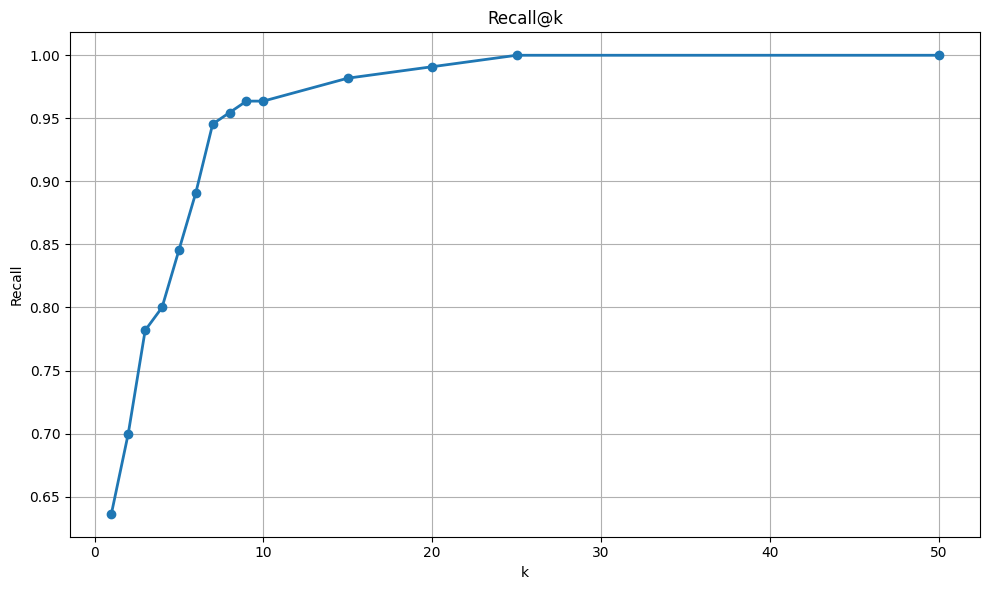

In [27]:
import matplotlib.pyplot as plt

  # Create a single plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot recall data
recall_data = df[df["metric"] == "recall"]
ax.plot(recall_data["k"], recall_data["score"], marker="o",
linewidth=2)

ax.set_title("Recall@k")
ax.set_xlabel("k")
ax.set_ylabel("Recall")
ax.grid(True)

plt.tight_layout()
plt.show()


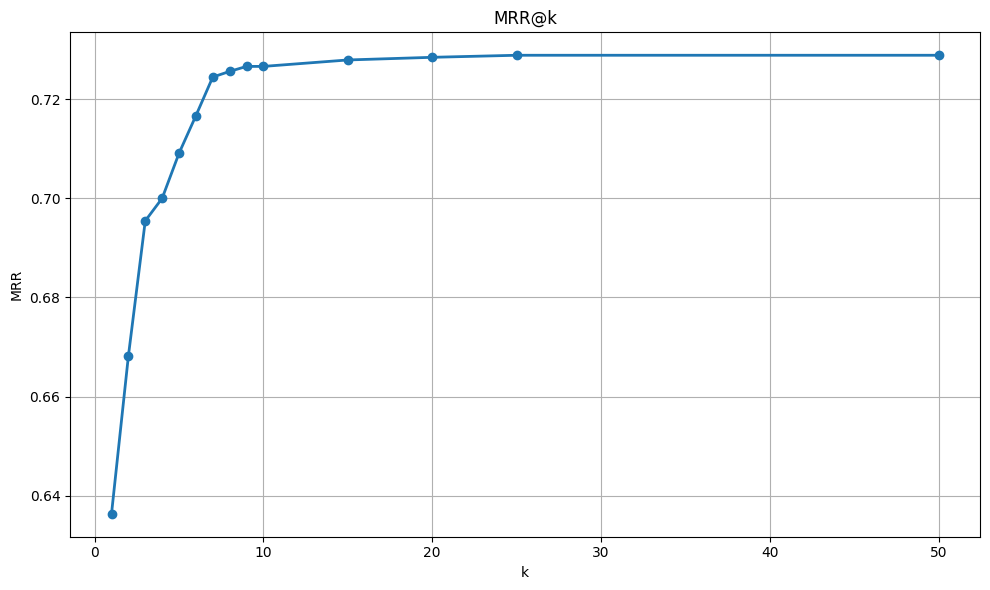

In [28]:
import matplotlib.pyplot as plt

  # Create a single plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot mrr data
mrr_data = df[df["metric"] == "mrr"]
ax.plot(mrr_data["k"], mrr_data["score"], marker="o",
linewidth=2)

ax.set_title("MRR@k")
ax.set_xlabel("k")
ax.set_ylabel("MRR")
ax.grid(True)

plt.tight_layout()
plt.show()


## 實驗更多不同超參

In [29]:
# Define strategies
STRATEGIES = [
    "text-embedding-3-small@400-200",
    "text-embedding-3-small@800-400",
    "text-embedding-3-large@800-400",
    "text-embedding-3-large@400-200",
]

In [30]:
from functools import partial

evaluation_results = []
experiment_id = str(uuid.uuid4())

for strategy in STRATEGIES:

    async def retrieve_documents_by_strategy(query):
        return await retrieve_documents(query, strategy)

    benchmark_result = await Eval(
        name=os.getenv("BRAINTRUST_PROJECT"),
        experiment_name=f"{experiment_id}-{strategy}",
        task=partial(retrieve_documents, strategy=strategy),
        data=evaluation_queries,
        scores=[evaluate_braintrust],
        metadata={
            "k": k
        },
    )

    performance_scores = benchmark_result.summary.scores

    for metric_name, score_data in performance_scores.items():
        metric_type, top_k = metric_name.split("@")
        evaluation_results.append(
            {
                "metric": metric_type,
                "k": int(top_k),
                "strategy": strategy,
                "score": score_data.score,
            }
        )
            

Experiment 407021ee-01e6-4128-9bcb-5165e5c11141-text-embedding-3-small@400-200 is running at https://www.braintrust.dev/app/Statementdog/p/openai-agents-fastapi-demo/experiments/407021ee-01e6-4128-9bcb-5165e5c11141-text-embedding-3-small%40400-200
openai-agents-fastapi-demo [experiment_name=407021ee-01e6-4128-9bcb-5165e5c11141-text-embedding-3-small@400-200] (data): 110it [00:00, 98039.41it/s]
openai-agents-fastapi-demo [experiment_name=407021ee-01e6-4128-9bcb-5165e5c11141-text-embedding-3-small@400-200] (tasks): 100%|██████████| 110/110 [00:23<00:00,  4.71it/s]



=========================SUMMARY=========================
407021ee-01e6-4128-9bcb-5165e5c11141-text-embedding-3-small@400-200 compared to 03bc8e10-20ed-42ed-848b-abdbc21887e2-text-embedding-3-small@800-400:
84.55% (+20.91%) 'mrr@1'     score	(28 improvements, 5 regressions)
90.76% (+18.10%) 'mrr@10'    score	(37 improvements, 7 regressions)
90.76% (+17.97%) 'mrr@15'    score	(37 improvements, 7 regressions)
89.09% (+22.27%) 'mrr@2'     score	(35 improvements, 5 regressions)
90.76% (+17.91%) 'mrr@20'    score	(37 improvements, 7 regressions)
90.79% (+17.91%) 'mrr@25'    score	(37 improvements, 7 regressions)
90.30% (+20.76%) 'mrr@3'     score	(36 improvements, 6 regressions)
90.76% (+20.76%) 'mrr@4'     score	(37 improvements, 7 regressions)
90.76% (+19.85%) 'mrr@5'     score	(37 improvements, 7 regressions)
90.79% (+17.91%) 'mrr@50'    score	(37 improvements, 7 regressions)
90.76% (+19.09%) 'mrr@6'     score	(37 improvements, 7 regressions)
90.76% (+18.31%) 'mrr@7'     score	(37 impro

Experiment 407021ee-01e6-4128-9bcb-5165e5c11141-text-embedding-3-small@800-400 is running at https://www.braintrust.dev/app/Statementdog/p/openai-agents-fastapi-demo/experiments/407021ee-01e6-4128-9bcb-5165e5c11141-text-embedding-3-small%40800-400
openai-agents-fastapi-demo [experiment_name=407021ee-01e6-4128-9bcb-5165e5c11141-text-embedding-3-small@800-400] (data): 110it [00:00, 238066.79it/s]
openai-agents-fastapi-demo [experiment_name=407021ee-01e6-4128-9bcb-5165e5c11141-text-embedding-3-small@800-400] (tasks): 100%|██████████| 110/110 [00:12<00:00,  9.01it/s]



=========================SUMMARY=========================
407021ee-01e6-4128-9bcb-5165e5c11141-text-embedding-3-small@800-400 compared to 407021ee-01e6-4128-9bcb-5165e5c11141-text-embedding-3-small@400-200:
63.64% (-20.91%) 'mrr@1'     score	(5 improvements, 28 regressions)
72.66% (-18.10%) 'mrr@10'    score	(7 improvements, 37 regressions)
72.79% (-17.97%) 'mrr@15'    score	(7 improvements, 37 regressions)
66.82% (-22.27%) 'mrr@2'     score	(5 improvements, 35 regressions)
72.84% (-17.91%) 'mrr@20'    score	(7 improvements, 37 regressions)
72.89% (-17.91%) 'mrr@25'    score	(7 improvements, 37 regressions)
69.55% (-20.76%) 'mrr@3'     score	(6 improvements, 36 regressions)
70.00% (-20.76%) 'mrr@4'     score	(7 improvements, 37 regressions)
70.91% (-19.85%) 'mrr@5'     score	(7 improvements, 37 regressions)
72.89% (-17.91%) 'mrr@50'    score	(7 improvements, 37 regressions)
71.67% (-19.09%) 'mrr@6'     score	(7 improvements, 37 regressions)
72.45% (-18.31%) 'mrr@7'     score	(7 improv

Experiment 407021ee-01e6-4128-9bcb-5165e5c11141-text-embedding-3-large@800-400 is running at https://www.braintrust.dev/app/Statementdog/p/openai-agents-fastapi-demo/experiments/407021ee-01e6-4128-9bcb-5165e5c11141-text-embedding-3-large%40800-400
openai-agents-fastapi-demo [experiment_name=407021ee-01e6-4128-9bcb-5165e5c11141-text-embedding-3-large@800-400] (data): 110it [00:00, 78504.92it/s]
openai-agents-fastapi-demo [experiment_name=407021ee-01e6-4128-9bcb-5165e5c11141-text-embedding-3-large@800-400] (tasks): 100%|██████████| 110/110 [00:22<00:00,  4.93it/s]



=========================SUMMARY=========================
407021ee-01e6-4128-9bcb-5165e5c11141-text-embedding-3-large@800-400 compared to 407021ee-01e6-4128-9bcb-5165e5c11141-text-embedding-3-small@800-400:
59.09% (-04.55%) 'mrr@1'     score	(4 improvements, 9 regressions)
74.02% (+01.36%) 'mrr@10'    score	(29 improvements, 13 regressions)
74.02% (+01.23%) 'mrr@15'    score	(29 improvements, 13 regressions)
68.18% (+01.36%) 'mrr@2'     score	(15 improvements, 11 regressions)
74.02% (+01.17%) 'mrr@20'    score	(29 improvements, 13 regressions)
74.02% (+01.13%) 'mrr@25'    score	(29 improvements, 13 regressions)
71.52% (+01.97%) 'mrr@3'     score	(18 improvements, 11 regressions)
72.88% (+02.88%) 'mrr@4'     score	(23 improvements, 12 regressions)
73.42% (+02.52%) 'mrr@5'     score	(26 improvements, 12 regressions)
74.02% (+01.13%) 'mrr@50'    score	(29 improvements, 13 regressions)
73.42% (+01.76%) 'mrr@6'     score	(26 improvements, 13 regressions)
73.81% (+01.37%) 'mrr@7'     score	

Experiment 407021ee-01e6-4128-9bcb-5165e5c11141-text-embedding-3-large@400-200 is running at https://www.braintrust.dev/app/Statementdog/p/openai-agents-fastapi-demo/experiments/407021ee-01e6-4128-9bcb-5165e5c11141-text-embedding-3-large%40400-200
openai-agents-fastapi-demo [experiment_name=407021ee-01e6-4128-9bcb-5165e5c11141-text-embedding-3-large@400-200] (data): 110it [00:00, 115545.56it/s]
openai-agents-fastapi-demo [experiment_name=407021ee-01e6-4128-9bcb-5165e5c11141-text-embedding-3-large@400-200] (tasks): 100%|██████████| 110/110 [00:42<00:00,  2.57it/s]



=========================SUMMARY=========================
407021ee-01e6-4128-9bcb-5165e5c11141-text-embedding-3-large@400-200 compared to 407021ee-01e6-4128-9bcb-5165e5c11141-text-embedding-3-large@800-400:
75.45% (+16.36%) 'mrr@1'     score	(28 improvements, 10 regressions)
85.61% (+11.59%) 'mrr@10'    score	(34 improvements, 13 regressions)
85.61% (+11.59%) 'mrr@15'    score	(34 improvements, 13 regressions)
82.73% (+14.55%) 'mrr@2'     score	(33 improvements, 12 regressions)
85.61% (+11.59%) 'mrr@20'    score	(34 improvements, 13 regressions)
85.61% (+11.59%) 'mrr@25'    score	(34 improvements, 13 regressions)
85.15% (+13.64%) 'mrr@3'     score	(34 improvements, 12 regressions)
85.61% (+12.73%) 'mrr@4'     score	(34 improvements, 12 regressions)
85.61% (+12.18%) 'mrr@5'     score	(34 improvements, 12 regressions)
85.62% (+11.61%) 'mrr@50'    score	(34 improvements, 13 regressions)
85.61% (+12.18%) 'mrr@6'     score	(34 improvements, 12 regressions)
85.61% (+11.79%) 'mrr@7'     scor

## 視覺化結果

In [34]:
import pandas as pd

evaluation_results = sorted(evaluation_results, key=lambda x: (x["metric"], x["k"]))
df = pd.DataFrame(evaluation_results)
df

metric   k                        strategy     score
0       mrr   1  text-embedding-3-small@400-200  0.845455
1       mrr   1  text-embedding-3-small@800-400  0.636364
2       mrr   1  text-embedding-3-large@800-400  0.590909
3       mrr   1  text-embedding-3-large@400-200  0.754545
4       mrr   2  text-embedding-3-small@400-200  0.890909
..      ...  ..                             ...       ...
107  recall  25  text-embedding-3-large@400-200  0.990909
108  recall  50  text-embedding-3-small@400-200  1.000000
109  recall  50  text-embedding-3-small@800-400  1.000000
110  recall  50  text-embedding-3-large@800-400  1.000000
111  recall  50  text-embedding-3-large@400-200  1.000000

[112 rows x 4 columns]

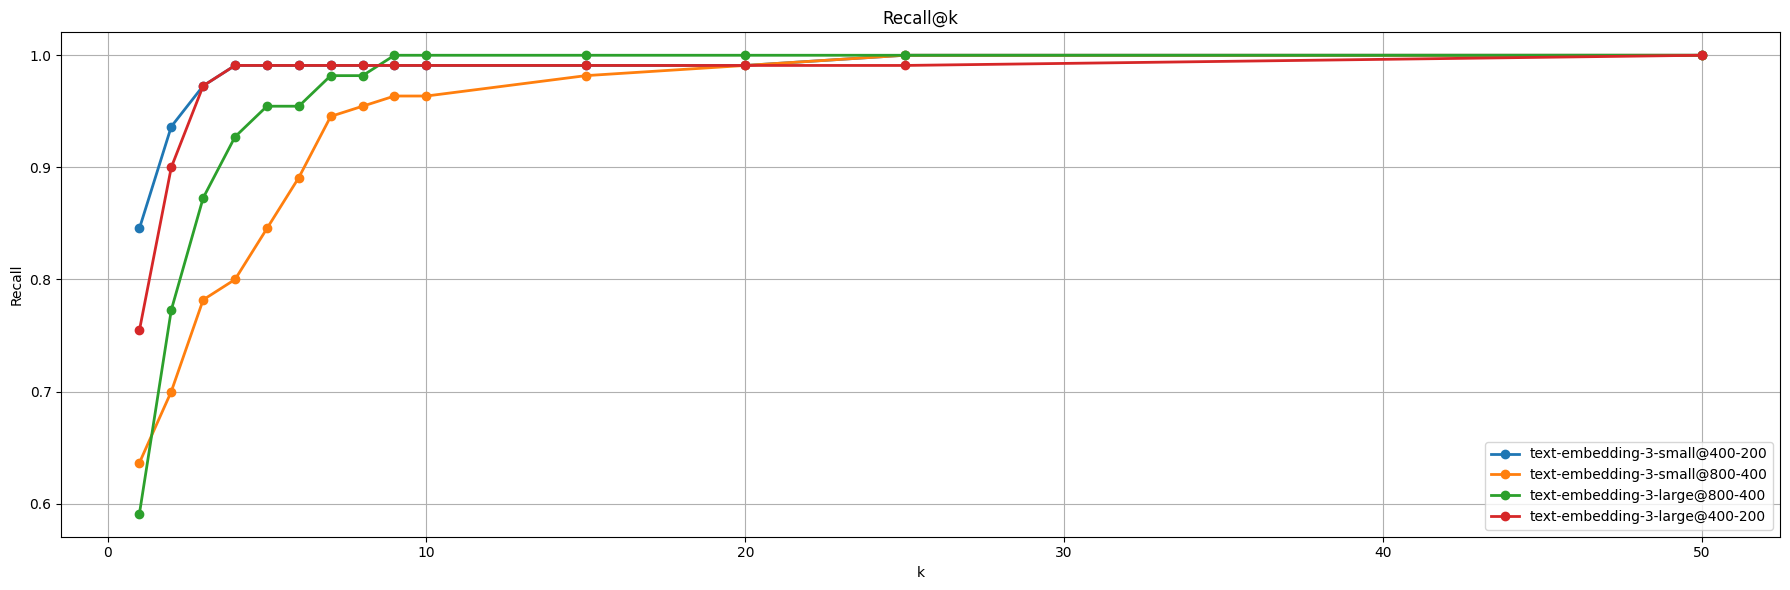

In [35]:
import matplotlib.pyplot as plt

# Create a single plot
fig, ax = plt.subplots(figsize=(18, 6))

for strategy in STRATEGIES:
    # Plot recall data - fix the boolean operator issue
    recall_data = df[(df["metric"] == "recall") & (df["strategy"] == strategy)]
    ax.plot(recall_data["k"], recall_data["score"], marker="o", label=strategy, linewidth=2)

ax.set_title("Recall@k")
ax.set_xlabel("k")
ax.set_ylabel("Recall")
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()

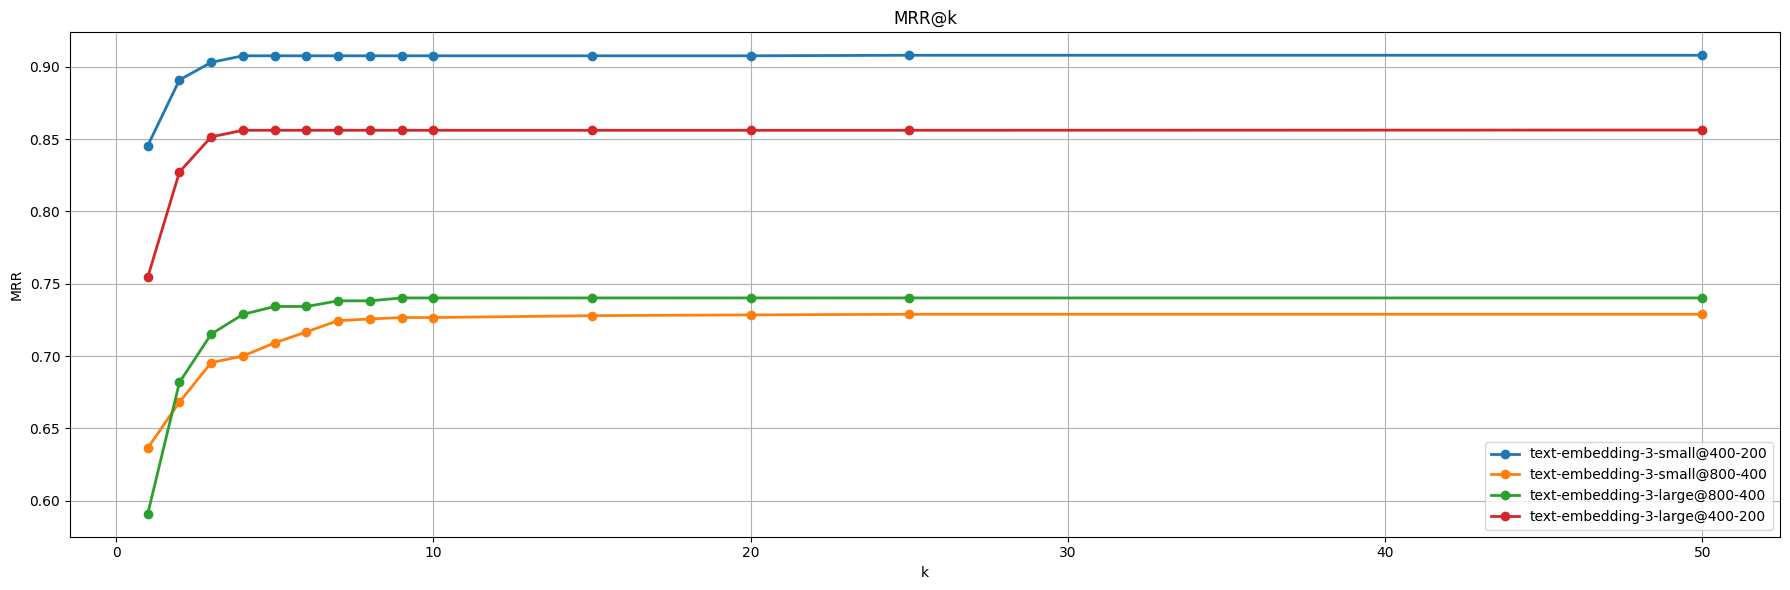

In [36]:
import matplotlib.pyplot as plt

# Create a single plot
fig, ax = plt.subplots(figsize=(18, 6))

for strategy in STRATEGIES:
    recall_data = df[(df["metric"] == "mrr") & (df["strategy"] == strategy)]
    ax.plot(recall_data["k"], recall_data["score"], marker="o", label=strategy, linewidth=2)

ax.set_title("MRR@k")
ax.set_xlabel("k")
ax.set_ylabel("MRR")
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()

## 信賴區間

比較兩次實驗是否有統計顯著性差異

In [43]:
from dataclasses import dataclass
import braintrust


@dataclass
class ExperimentConfig:
    experiment_id: str
    project_name: str
    label: str

    def get_results(self):
        return [
            {
                "preds": [item["document_id"] for item in row["output"]],
                "labels": [row["metadata"]["document_id"]],
            }
            for row in braintrust.init(
                project=self.project_name, experiment=self.experiment_id, open=True
            )
            if row["root_span_id"] == row["span_id"]
        ]


configs = [
    ExperimentConfig(
        experiment_id="407021ee-01e6-4128-9bcb-5165e5c11141-text-embedding-3-small@400-200",
        project_name=os.getenv("BRAINTRUST_PROJECT"),
        label="text-embedding-3-small-400-200",
    ),
    ExperimentConfig(
        experiment_id="407021ee-01e6-4128-9bcb-5165e5c11141-text-embedding-3-small@800-400",
        project_name=os.getenv("BRAINTRUST_PROJECT"),
        label="text-embedding-3-small-800-400",
    ),    
    #ExperimentConfig(
    #    experiment_id="407021ee-01e6-4128-9bcb-5165e5c11141-text-embedding-3-large@400-200",
    #    project_name=os.getenv("BRAINTRUST_PROJECT"),
    #    label="text-embedding-3-large-400-200",
    #),
    #ExperimentConfig(
    #    experiment_id="407021ee-01e6-4128-9bcb-5165e5c11141-text-embedding-3-large@800-400",
    #    project_name=os.getenv("BRAINTRUST_PROJECT"),
    #    label="text-embedding-3-large-800-400",
    #),    
]

In [44]:
import numpy as np
import pandas as pd

metrics = [("recall", calculate_recall), ("mrr", calculate_mrr)]

def bootstrap_samples(config: ExperimentConfig, n_samples: int = 1000):
    means_list = []
    stds_list = []
    items = config.get_results()

    # Sample with replacement n_samples times
    for _ in range(n_samples):
        sample = np.random.choice(items, size=len(items), replace=True)

        sample_scores = []

        # For each sample, we treat it as a new experiment and compute the metrics we care about
        for row in sample:
            row_scores = {}
            for metric_name, metric_fn in metrics:
                for subset_k in k:
                    metric_key = f"{metric_name}@{subset_k}"
                    row_scores[metric_key] = metric_fn(
                        row["preds"][:subset_k], row["labels"]
                    )
            sample_scores.append(row_scores)

        # We then use this to compute means and standard deviations for each metric
        sample_df = pd.DataFrame(sample_scores)
        means_list.append(sample_df.mean().to_dict())
        stds_list.append(sample_df.std().to_dict())

    # Finally we return a dataframe of means and standard deviations for each metric
    means_df = pd.DataFrame(means_list)
    stds_df = pd.DataFrame(stds_list)

    return means_df, stds_df

In [45]:
from dataclasses import dataclass
from typing import Dict


@dataclass
class BootstrapResults:
    label: str
    means: Dict[str, float]
    stds: Dict[str, float]
    ci_lower: Dict[str, float]
    ci_upper: Dict[str, float]


def calculate_bootstrap_stats(
    means_df: pd.DataFrame, stds_df: pd.DataFrame, label: str
) -> BootstrapResults:
    """Calculate bootstrap statistics for a given experiment config"""
    # Calculate mean and confidence intervals for each metric
    results = {}
    ci_lower = {}
    ci_upper = {}
    stds = {}

    # For each metric column
    for col in means_df.columns:
        results[col] = means_df[col].mean()
        stds[col] = stds_df[col].std()
        ci_lower[col] = np.percentile(means_df[col], 2.5)
        ci_upper[col] = np.percentile(means_df[col], 97.5)

    return BootstrapResults(
        means=results,
        ci_lower=ci_lower,
        ci_upper=ci_upper,
        label=label,
        stds=stds,
    )

In [46]:
bootstrap_dfs = [bootstrap_samples(config, n_samples=1000) for config in configs]
bootstrap_results = [
    calculate_bootstrap_stats(dfs[0], dfs[1], config.label)
    for dfs, config in zip(bootstrap_dfs, configs)
]
bootstrap_results


[BootstrapResults(label='text-embedding-3-small-400-200', means={'recall@1': np.float64(0.8462818181818181), 'recall@2': np.float64(0.9380636363636363), 'recall@3': np.float64(0.9737), 'recall@4': np.float64(0.9912545454545455), 'recall@5': np.float64(0.9912545454545455), 'recall@6': np.float64(0.9912545454545455), 'recall@7': np.float64(0.9912545454545455), 'recall@8': np.float64(0.9912545454545455), 'recall@9': np.float64(0.9912545454545455), 'recall@10': np.float64(0.9912545454545455), 'recall@15': np.float64(0.9912545454545455), 'recall@20': np.float64(0.9912545454545455), 'recall@25': np.float64(1.0), 'recall@50': np.float64(1.0), 'mrr@1': np.float64(0.8462818181818181), 'mrr@2': np.float64(0.8921727272727272), 'mrr@3': np.float64(0.904051515151515), 'mrr@4': np.float64(0.9084401515151516), 'mrr@5': np.float64(0.9084401515151516), 'mrr@6': np.float64(0.9084401515151516), 'mrr@7': np.float64(0.9084401515151516), 'mrr@8': np.float64(0.9084401515151516), 'mrr@9': np.float64(0.9084401

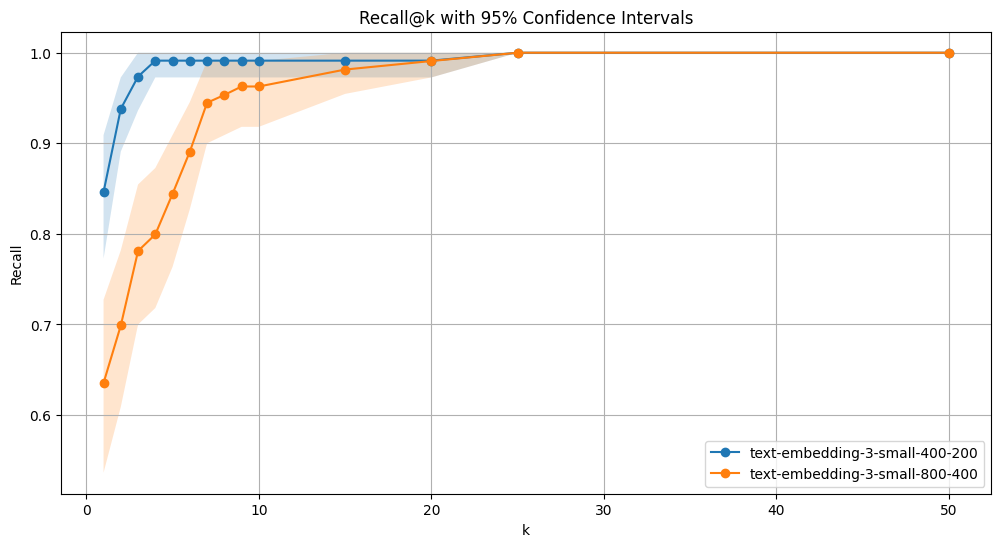

In [47]:
import matplotlib.pyplot as plt
from typing import List


def plot_recall_at_k(bootstrap_results: List[BootstrapResults]):
    plt.figure(figsize=(12, 6))

    # Extract k values from the metrics in the first result
    k_values = []
    for key in bootstrap_results[0].means.keys():
        if key.startswith("recall@"):
            k = int(key.split("@")[1])
            k_values.append(k)
    k_values.sort()

    for results in bootstrap_results:
        # Extract recall metrics
        recall_means = [results.means[f"recall@{k}"] for k in k_values]
        recall_lower = [results.ci_lower[f"recall@{k}"] for k in k_values]
        recall_upper = [results.ci_upper[f"recall@{k}"] for k in k_values]

        # Plot line and confidence interval
        plt.plot(k_values, recall_means, marker="o", label=results.label)
        plt.fill_between(k_values, recall_lower, recall_upper, alpha=0.2)

    plt.xlabel("k")
    plt.ylabel("Recall")
    plt.title("Recall@k with 95% Confidence Intervals")
    plt.grid(True)
    plt.legend()


# Plot the results
plot_recall_at_k(bootstrap_results)